# Analysis of Feature Selection Techniques

## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd     # for data processing
import numpy as np      # for sklearn
import matplotlib.pyplot as plt # for plotting the coefficients
from sklearn.tree import DecisionTreeClassifier # for classification
from sklearn.metrics import mean_squared_error, jaccard_similarity_score, accuracy_score, f1_score # for measuring accuracy
from sklearn.model_selection import train_test_split # for splitting the data
import warnings
warnings.simplefilter('ignore')

In [ ]:
test_df = pd.read_csv("../../content/drive/My Drive/test.csv")
train_df = pd.read_csv("../../content/drive/My Drive/train.csv")

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [ ]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [ ]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [ ]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Deck           891 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 83.7+ KB


In [ ]:

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [ ]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [ ]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [ ]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

In [ ]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [ ]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,1,0,3,0,22,1,0,7,0,8,1
1,2,1,1,1,38,1,0,71,1,3,3
2,3,1,3,1,26,0,0,7,0,8,2
3,4,1,1,1,35,1,0,53,0,3,3
4,5,0,3,0,35,0,0,8,0,8,1


## Using LassoCV

Train Data:  (712, 11) Cross Validation Data:  (89, 11) Test Data:  (90, 11)
RMSE of Lasso  :  0.4395925969844876


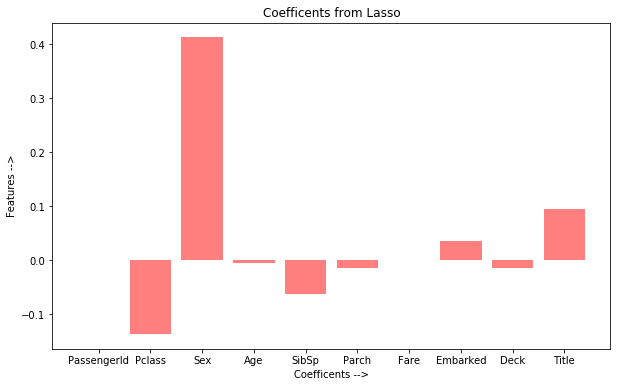

In [ ]:
from sklearn.linear_model import LassoCV

rs = 1
# splitting the data into training, testing and validation sets
Train, Test = train_test_split(train_df, test_size= 0.2, random_state= rs)

CV, Test = train_test_split(Test, test_size=0.5, random_state = rs)

print("Train Data: ", Train.shape,"Cross Validation Data: ", CV.shape,"Test Data: ", Test.shape)

# split the data in dependent and independent variable
Train_y = np.array(Train["Survived"])
CV_y = np.array(CV["Survived"])
Test_y = np.array(Test["Survived"])
Train_x = Train.drop(["Survived"], axis = 1)
CV_x = CV.drop(["Survived"], axis = 1)
Test_x = Test.drop(["Survived"], axis = 1)

# performing LassoCV for variable selection
# lasso is linear regression with l1 regularization
modellasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0001, 10, 1000], cv=5, random_state=rs).fit(Train_x, Train_y)
lassopred = modellasso.predict(CV_x)
print("RMSE of Lasso  : ", np.sqrt(mean_squared_error(lassopred, CV_y)))

coeff = modellasso.coef_

x = list(Train_x)
x_pos = [i for i, _ in enumerate(x)]

# Visualizing the importance (value of their coefficients) of the parameters
#### Uncomment the following code to view the graph showing the features with their coefficients
plt.figure(figsize = (10,6))
plt.bar(x_pos, coeff, color='red', alpha=0.5)
plt.ylabel("Features -->")
plt.xlabel("Coefficents -->")
plt.title("Coefficents from Lasso")
plt.xticks(x_pos, x)
plt.show()
####


####
# Uncomment the following line of code to view the coefficients
# modellasso.coef_
####



### With positive coeficients only

In [ ]:
thresh =0.05

# Creating the model using Descision Tree Classifier
ModelDT = DecisionTreeClassifier(criterion='entropy')
#The features used for model are the ones who have the coefficients greater than 0.3 from the lassoCV
#This can be further increased or decreased to increase or decrease number of features respectively when required.
#Survived is the target variable
ModelDT.fit(Train.drop("Survived", axis=1).loc[:,modellasso.coef_>thresh],Train["Survived"])

# predicting the values for Test feature set
yhat= ModelDT.predict(Test.drop("Survived", axis=1).loc[:,modellasso.coef_>thresh])

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(Test["Survived"], yhat), "\n"
      "Accuracy Score     : ",accuracy_score(Test["Survived"], yhat),"\n"
      "F1 Score           : ",f1_score(Test["Survived"], yhat, average="weighted"))

lassoCV_acc = accuracy_score(Test["Survived"], yhat)
lassoCV_features = Train.drop("Survived", axis=1).loc[:,modellasso.coef_>thresh].columns.values

####
# uncomment the following line of code to view the name of the coolumns (feature variables)
Train.drop("Survived", axis=1).loc[:,modellasso.coef_>thresh].columns
####

The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8 
Accuracy Score     :  0.8 
F1 Score           :  0.8


Index(['Sex', 'Title'], dtype='object')

### With negative coefficients as well

In [ ]:
thresh_pos, thresh_neg =0.05, -0.05

# Creating the model using Descision Tree Classifier
ModelDT = DecisionTreeClassifier(criterion='entropy')
#The features used for model are the ones who have the coefficients greater than 0.3 from the lassoCV
#This can be further increased or decreased to increase or decrease number of features respectively when required.
#Survived is the target variable
ModelDT.fit(Train.drop("Survived", axis=1).loc[:,(modellasso.coef_>thresh_pos) | (modellasso.coef_<thresh_neg) ],Train["Survived"])

# predicting the values for Test feature set
yhat= ModelDT.predict(Test.drop("Survived", axis=1).loc[:,(modellasso.coef_>thresh_pos) | (modellasso.coef_<thresh_neg) ])

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(Test["Survived"], yhat), "\n"
      "Accuracy Score     : ",accuracy_score(Test["Survived"], yhat),"\n"
      "F1 Score           : ",f1_score(Test["Survived"], yhat, average="weighted"))

lassoCV_acc = accuracy_score(Test["Survived"], yhat)
lassoCV_features = Train.drop("Survived", axis=1).loc[:,(modellasso.coef_>thresh_pos) | (modellasso.coef_<thresh_neg) ].columns.values

####
# uncomment the following line of code to view the name of the coolumns (feature variables)
Train.drop("Survived", axis=1).loc[:,(modellasso.coef_>thresh_pos) | (modellasso.coef_<thresh_neg) ].columns
####

The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8222222222222222 
Accuracy Score     :  0.8222222222222222 
F1 Score           :  0.8189300411522633


Index(['Pclass', 'Sex', 'SibSp', 'Title'], dtype='object')

In [ ]:
Train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
301,302,1,3,0,38,2,0,23,2,8,1
309,310,1,1,1,30,0,0,56,1,5,2
516,517,1,2,1,34,0,0,10,0,6,3
120,121,0,2,0,21,2,0,73,0,8,1
570,571,1,2,0,62,0,0,10,0,8,1


## Using Correlation

In [ ]:
# 'PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp',
#        'Parch', 'Fare', 'Embarked', 'Deck', 'Title'

corrmat=train_df.corr()
# list((corrmat["Survived"]>1)['Survived'].index.values)
select_fet = set(list(corrmat[(corrmat["Survived"]>0.5)].index.values))
# for i in select_fet:
corrmat = corrmat[(corrmat["Survived"]>0.5)].transpose()
print(select_fet)
# for corrmat select_fet
# print(corrmat.transpose())
# print(corrmat[select_fet])
for i in corrmat:
    select_fet = select_fet.intersection(set(corrmat[(corrmat[i]>0.5)].index.values))
    # print(corrmat[(corrmat[i]>0.5)].index.values)
corrmat=train_df.corr()
select_fet = set(list(corrmat[(corrmat["Survived"]>0.5)].index.values))
corrmat = corrmat[(corrmat["Survived"]>0.5)].transpose()
for i in corrmat:
    select_fet = select_fet.intersection(set(corrmat[(corrmat[i]>0.5)].index.values))


{'Survived', 'Sex'}


In [ ]:
# Finding the correlation between the features
corrmat=train_df.corr()
acc= []
feat = []
x = []
for i in np.linspace(0,1, 20):
  print("i is", i)
  if i==1:
    break
  
  # Selecting the variables with correlation greater than 0.5 or less than -0.5 as features to train the model
  Features_list = list(corrmat[(corrmat["Survived"]>i) | (corrmat["Survived"]<-i)]["Survived"].index.values)
  Features_list.remove("Survived")
  if len(Features_list)==0:
    break
  # Visualizing the correlation between the features through a heat map
  # Here only the selected columns (variables) are used to plot.
  #### no need of heat for looping through various threshold
  # import seaborn as sns
  # plt.figure(figsize=(20,20))
  # sns.heatmap(train_df[Features_list+["Survived"]].corr(), annot=True,cmap="RdYlGn")
  ####
  X = train_df[Features_list].values
  y = train_df["Survived"].values
  X_train,X_test, y_train,y_test = train_test_split(X,y, random_state=0)
  print("Training Data X: ",X_train.shape, " Testing Data X: ",X_test.shape, "\n"
        "Training Data y: ",y_train.shape, " Testing Data y: ",y_test.shape)
  # Creating the model using Descision Tree Classifier
  ModelDT = DecisionTreeClassifier(criterion='entropy')
  #The features used for model are the ones who have the vairables having correlation greater than 0.5 or less than -0.5
  #This can be further increased or decreased to increase or decrease number of features respectively when required.
  #DBLVEFORC is the target variable
  ModelDT.fit(X_train,y_train)

  # predicting the values for Test feature set
  yhat= ModelDT.predict(X_test)

  #printing the accuracy
  print("The metrics for the trained model are as follows:","\n"
        "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
        "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
        "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

  corr_acc = accuracy_score(y_test, yhat)
  corr_features = Features_list
  x.append(i)
  acc.append(corr_acc)
  feat.append(corr_features)

plt.plot(x, acc)
plt.title("Threshold VS Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Threshold")

In [ ]:
threshold_max = x[acc.index(max(acc))]

In [ ]:
print(threshold_max)

0.15789473684210525


In [ ]:
# Selecting the variables with correlation greater than 0.5 or less than -0.5 as features to train the model
Features_list = list(corrmat[(corrmat["Survived"]>threshold_max) | (corrmat["Survived"]<-threshold_max)]["Survived"].index.values)
Features_list.remove("Survived")
# Visualizing the correlation between the features through a heat map
# Here only the selected columns (variables) are used to plot.
#### no need of heat for looping through various threshold
# import seaborn as sns
# plt.figure(figsize=(20,20))
# sns.heatmap(train_df[Features_list+["Survived"]].corr(), annot=True,cmap="RdYlGn")
####
X = train_df[Features_list].values
y = train_df["Survived"].values
X_train,X_test, y_train,y_test = train_test_split(X,y, random_state=0)
print("Training Data X: ",X_train.shape, " Testing Data X: ",X_test.shape, "\n"
      "Training Data y: ",y_train.shape, " Testing Data y: ",y_test.shape)
# Creating the model using Descision Tree Classifier
ModelDT = DecisionTreeClassifier(criterion='entropy')
#The features used for model are the ones who have the vairables having correlation greater than 0.5 or less than -0.5
#This can be further increased or decreased to increase or decrease number of features respectively when required.
#DBLVEFORC is the target variable
ModelDT.fit(X_train,y_train)

# predicting the values for Test feature set
yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

corr_acc = accuracy_score(y_test, yhat)
corr_features = Features_list
print(corr_features)

Training Data X:  (668, 5)  Testing Data X:  (223, 5) 
Training Data y:  (668,)  Testing Data y:  (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8251121076233184 
Accuracy Score     :  0.8251121076233184 
F1 Score           :  0.8229045949458927
['Pclass', 'Sex', 'Fare', 'Deck', 'Title']


## Using SelectKBest for feature Selection mutual_info_classif

(668, 1) (223, 1) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7847533632286996 
Accuracy Score     :  0.7847533632286996 
F1 Score           :  0.7817728858087603
(668, 2) (223, 2) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7623318385650224 
Accuracy Score     :  0.7623318385650224 
F1 Score           :  0.7613966216100126
(668, 3) (223, 3) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7668161434977578 
Accuracy Score     :  0.7668161434977578 
F1 Score           :  0.7581594310367548
(668, 4) (223, 4) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8251121076233184 
Accuracy Score     :  0.8251121076233184 
F1 Score           :  0.8208756162650385
(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8071748878923767 
Accuracy Score     :  0.8071748878923767 
F

Text(0, 0.5, 'Accuracy')

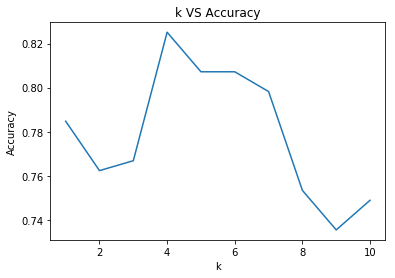

In [ ]:
import numpy as np 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif #f_classif chi2
from sklearn.tree import DecisionTreeClassifier

acc = []
ks = []
for k in range(1,11):
  selector = SelectKBest(mutual_info_classif, k=k)
  selector.fit(train_df.drop("Survived", axis=1),train_df["Survived"])
  X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
  y = train_df["Survived"].values

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  ModelDT = DecisionTreeClassifier(criterion='entropy')

  ModelDT.fit(X_train,y_train)

  yhat= ModelDT.predict(X_test)

  #printing the accuracy
  print("The metrics for the trained model are as follows:","\n"
        "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
        "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
        "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

  mutual_info_acc = accuracy_score(y_test, yhat)
  mutual_info_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values
  ks.append(k)
  acc.append(mutual_info_acc)

plt.plot(ks, acc)
plt.title("k VS Accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")

In [ ]:
optimum_k =  ks[acc.index(max(acc))]
print(optimum_k )

4


In [ ]:
selector = SelectKBest(mutual_info_classif, k=optimum_k)
selector.fit(train_df.drop("Survived", axis=1),train_df["Survived"])
X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
y = train_df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ModelDT = DecisionTreeClassifier(criterion='entropy')

ModelDT.fit(X_train,y_train)

yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

mutual_info_acc = accuracy_score(y_test, yhat)
mutual_info_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values

(668, 4) (223, 4) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8251121076233184 
Accuracy Score     :  0.8251121076233184 
F1 Score           :  0.8208756162650385


In [ ]:
mutual_info_features

array(['Pclass', 'Sex', 'Fare', 'Title'], dtype=object)

## Using SelectKBest f_classif

(668, 1) (223, 1) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7847533632286996 
Accuracy Score     :  0.7847533632286996 
F1 Score           :  0.7817728858087603
(668, 2) (223, 2) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7623318385650224 
Accuracy Score     :  0.7623318385650224 
F1 Score           :  0.7613966216100126
(668, 3) (223, 3) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.757847533632287 
Accuracy Score     :  0.757847533632287 
F1 Score           :  0.734389720013566
(668, 4) (223, 4) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.757847533632287 
Accuracy Score     :  0.757847533632287 
F1 Score           :  0.740552497602487
(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8116591928251121 
Accuracy Score     :  0.8116591928251121 
F1 Scor

Text(0, 0.5, 'Accuracy')

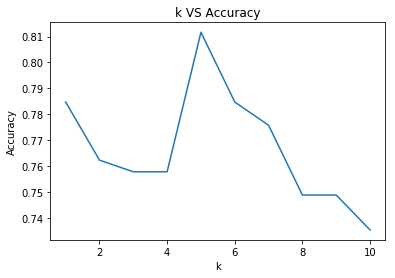

In [ ]:
import numpy as np 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif #f_classif chi2
from sklearn.tree import DecisionTreeClassifier

acc = []
ks = []
for k in range(1,11):
  selector = SelectKBest(f_classif, k=k)
  selector.fit(train_df.drop("Survived", axis=1),train_df["Survived"])
  X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
  y = train_df["Survived"].values

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  ModelDT = DecisionTreeClassifier(criterion='entropy')

  ModelDT.fit(X_train,y_train)

  yhat= ModelDT.predict(X_test)

  #printing the accuracy
  print("The metrics for the trained model are as follows:","\n"
        "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
        "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
        "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

  f_classif_acc = accuracy_score(y_test, yhat)
  f_classif_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values
  ks.append(k)
  acc.append(f_classif_acc)

plt.plot(ks, acc)
plt.title("k VS Accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")

In [ ]:
optimum_k =  ks[acc.index(max(acc))]
print(optimum_k )

5


In [ ]:
selector = SelectKBest(f_classif, k=optimum_k)
selector.fit(train_df.drop("Survived", axis=1),train_df["Survived"])
X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
y = train_df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ModelDT = DecisionTreeClassifier(criterion='entropy')

ModelDT.fit(X_train,y_train)

yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

f_classif_acc = accuracy_score(y_test, yhat)
f_classif_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values

(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8116591928251121 
Accuracy Score     :  0.8116591928251121 
F1 Score           :  0.8067796883569378


In [ ]:
f_classif_features

array(['Pclass', 'Sex', 'Fare', 'Deck', 'Title'], dtype=object)

## Using Chi Squared

(668, 1) (223, 1) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.672645739910314 
Accuracy Score     :  0.672645739910314 
F1 Score           :  0.6463193920373662
(668, 2) (223, 2) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7892376681614349 
Accuracy Score     :  0.7892376681614349 
F1 Score           :  0.7818359257092146
(668, 3) (223, 3) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7668161434977578 
Accuracy Score     :  0.7668161434977578 
F1 Score           :  0.7581594310367548
(668, 4) (223, 4) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7937219730941704 
Accuracy Score     :  0.7937219730941704 
F1 Score           :  0.7883777539147413
(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8116591928251121 
Accuracy Score     :  0.8116591928251121 
F1 

Text(0, 0.5, 'Accuracy')

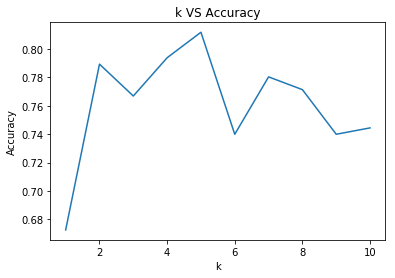

In [ ]:
import numpy as np 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 #f_classif chi2

acc = []
ks = []
for k in range(1,11):
  selector = SelectKBest(chi2, k=k)
  selector.fit(train_df.drop("Survived", axis=1),train_df["Survived"])
  X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
  y = train_df["Survived"].values

  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  ModelDT = DecisionTreeClassifier(criterion='entropy')

  ModelDT.fit(X_train,y_train)

  yhat= ModelDT.predict(X_test)

  #printing the accuracy
  print("The metrics for the trained model are as follows:","\n"
        "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
        "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
        "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

  chi2_acc = accuracy_score(y_test, yhat)
  chi2_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values
  ks.append(k)
  acc.append(chi2_acc)

plt.plot(ks, acc)
plt.title("k VS Accuracy")
plt.xlabel("k")
plt.ylabel("Accuracy")

In [ ]:
optimum_k =  ks[acc.index(max(acc))]
print(optimum_k )

5


In [ ]:
selector = SelectKBest(chi2, k=optimum_k)
selector.fit(train_df.drop("Survived", axis=1),train_df["Survived"])
X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
y = train_df["Survived"].values

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

ModelDT = DecisionTreeClassifier(criterion='entropy')

ModelDT.fit(X_train,y_train)

yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

chi2_acc = accuracy_score(y_test, yhat)
chi2_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values

(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.8071748878923767 
Accuracy Score     :  0.8071748878923767 
F1 Score           :  0.8025038845999144


In [ ]:
chi2_features

array(['Pclass', 'Sex', 'Fare', 'Deck', 'Title'], dtype=object)

## Using RFE with min_features_to_select = 2

Optimal number of features : 5


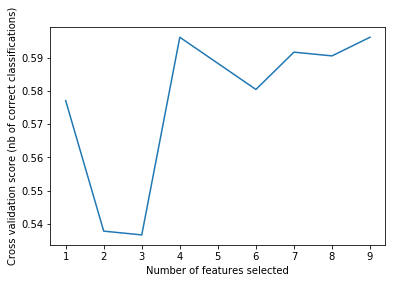

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

ModelDT = DecisionTreeClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=ModelDT, step=1, cv=StratifiedKFold(2),
              min_features_to_select = 2,
              scoring='accuracy')
X = train_df.drop("Survived", axis=1).values
y = train_df["Survived"].values
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.get_support(indices=True)

array([0, 1, 3, 6, 9])

In [ ]:
rfecv.n_features_ ## The number of features selected

5

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop("Survived", axis=1).iloc[:,rfecv.get_support(indices=True)].values,train_df["Survived"].values, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


ModelDT.fit(X_train,y_train)

yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

rfe_2_acc = accuracy_score(y_test, yhat)
rfe_2_features =train_df.drop("Survived", axis=1).iloc[:,rfecv.get_support(indices=True)].columns.values


(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7354260089686099 
Accuracy Score     :  0.7354260089686099 
F1 Score           :  0.7333409684471908


In [ ]:
rfe_2_features

array(['PassengerId', 'Pclass', 'Age', 'Fare', 'Title'], dtype=object)

## Using RFE with min_features_to_select = 1

Optimal number of features : 5


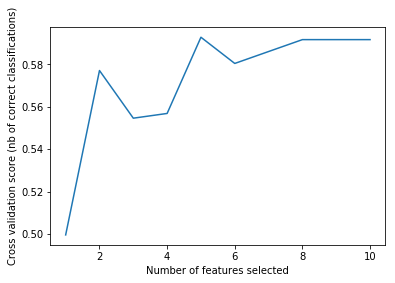

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

ModelDT = DecisionTreeClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=ModelDT, step=1, cv=StratifiedKFold(2),
              min_features_to_select = 1,
              scoring='accuracy')
X = train_df.drop("Survived", axis=1).values
y = train_df["Survived"].values
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
rfecv.get_support(indices=True)

array([0, 1, 3, 6, 9])

In [ ]:
rfecv.n_features_ ## The number of features selected

5

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df.drop("Survived", axis=1).iloc[:,rfecv.get_support(indices=True)].values,train_df["Survived"].values, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


ModelDT.fit(X_train,y_train)

yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

rfe_1_acc = accuracy_score(y_test, yhat)
rfe_1_features =train_df.drop("Survived", axis=1).iloc[:,rfecv.get_support(indices=True)].columns.values


(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7399103139013453 
Accuracy Score     :  0.7399103139013453 
F1 Score           :  0.7375745042726398


In [ ]:
rfe_1_features 

array(['PassengerId', 'Pclass', 'Age', 'Fare', 'Title'], dtype=object)

## Using Tree based feature selection along with SelectFromModel

(668, 1) (223, 1) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7847533632286996 
Accuracy Score     :  0.7847533632286996 
F1 Score           :  0.7817728858087603
(668, 2) (223, 2) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.6995515695067265 
Accuracy Score     :  0.6995515695067265 
F1 Score           :  0.691246082019865
(668, 3) (223, 3) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.6860986547085202 
Accuracy Score     :  0.6860986547085202 
F1 Score           :  0.6799842124453734
(668, 4) (223, 4) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.726457399103139 
Accuracy Score     :  0.726457399103139 
F1 Score           :  0.7207102414277302
(668, 5) (223, 5) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.726457399103139 
Accuracy Score     :  0.726457399103139 
F1 Sco

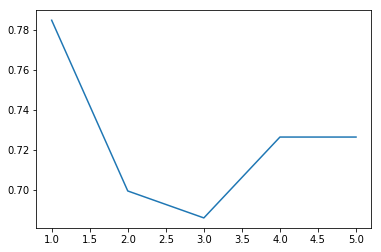

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

X = train_df.drop("Survived", axis=1).values
y = train_df["Survived"].values

clf = ExtraTreesClassifier(n_estimators=150)
clf = clf.fit(X, y)

# clf.feature_importances_ 

n_feat= []
acc = []

for i in range(1, 6):
  selector = SelectFromModel(clf, prefit=True, max_features=i)
  selector.get_support(indices=True)       
  X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
  y = train_df["Survived"].values
  X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  from sklearn.tree import DecisionTreeClassifier

  # ModelDT = DecisionTreeClassifier(criterion='entropy')
  ModelDT = ExtraTreesClassifier()
  ModelDT.fit(X_train,y_train)

  yhat= ModelDT.predict(X_test)

  #printing the accuracy
  print("The metrics for the trained model are as follows:","\n"
        "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
        "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
        "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

  tree_acc = accuracy_score(y_test, yhat)
  tree_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values
  acc.append(tree_acc)
  n_feat.append(i)

plt.plot(n_feat, acc)

In [ ]:
optimum_max_feat = n_feat[acc.index(max(acc))]
print(optimum_max_feat)

1


In [ ]:
selector = SelectFromModel(clf, prefit=True, max_features=optimum_max_feat)
selector.get_support(indices=True)       
X = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].values
y = train_df["Survived"].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.tree import DecisionTreeClassifier

# ModelDT = DecisionTreeClassifier(criterion='entropy')
ModelDT = ExtraTreesClassifier()
ModelDT.fit(X_train,y_train)

yhat= ModelDT.predict(X_test)

#printing the accuracy
print("The metrics for the trained model are as follows:","\n"
      "Jaccard Similarity : ",jaccard_similarity_score(y_test, yhat), "\n"
      "Accuracy Score     : ",accuracy_score(y_test, yhat),"\n"
      "F1 Score           : ",f1_score(y_test, yhat, average="weighted"))

tree_acc = accuracy_score(y_test, yhat)
tree_features = train_df.drop("Survived", axis=1).iloc[:,selector.get_support(indices=True)].columns.values

(668, 1) (223, 1) (668,) (223,)
The metrics for the trained model are as follows: 
Jaccard Similarity :  0.7847533632286996 
Accuracy Score     :  0.7847533632286996 
F1 Score           :  0.7817728858087603


In [ ]:
tree_features

array(['Sex'], dtype=object)

# Comparison of Number of Features and Accuracy of all the above technique used

In [ ]:
technique = ["LassoCV", "Correlation", "mutual_info", "f_classif", "chi2", "rfe_2_acc", "rfe_1_acc", "Tree Based" ]
technique.reverse() 

features = [tree_features,rfe_1_features,rfe_2_features,chi2_features,f_classif_features,
            mutual_info_features,corr_features,lassoCV_features]

accuracy = [tree_acc,rfe_1_acc,rfe_2_acc,chi2_acc,f_classif_acc,mutual_info_acc,corr_acc,lassoCV_acc]

features_count=[len(i) for i in features]

df_comparison = pd.DataFrame({"Technique": technique,
                              "Accuracy": accuracy,
                              "Feature Count": features_count, 
                              "Features": [",".join(i) for i in features]
                              })

lassoCV_des = 'A regression model that uses L1 regularization technique is called Lasso Regression.'+\
              ' Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of'+\
              ' magnitude” of coefficient as penalty term to the loss function.'+\
              ' Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether.'+\
              ' So, this works well for feature selection in case we have a huge number of features.'
rfe_des = 'Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), '+\
          'recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.'+\
          ' First, the estimator is trained on the initial set of features and the importance of each feature is obtained '+\
          'either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features'+\
          ' are pruned from current set of features.That procedure is recursively repeated on the pruned '+\
          'set until the desired number of features to select is eventually reached.'
chi2_des = 'Mathematically, a Chi-Square test is done on two distributions to determine the level of similarity'+\
          ' of their respective variances. In its null hypothesis, it assumes that the given distributions are independent.'+\
          ' This test thus can be used to determine the best features for a given dataset by determining the '+\
          'features on which the output class label is most dependent on. For each feature in the dataset, the chi2 '+\
          'is calculated and then ordered in descending order according to the chi2 value. '+\
          'The higher the value of chi2, the more dependent the output label is on the feature and higher the '+\
          'importance the feature has on determining the output.'
f_classif_des= 'Computes the ANOVA F-value for the provided sample.'
mutual_info_des = 'In probability theory and information theory, the mutual information (MI) of two random variables is a measure of the mutual dependence between the two variables. More specifically, it quantifies the "amount of information" obtained about one random variable through observing the other random variable.'
corr_des = 'Here pearson\'s correlation coefficient is used. It is the  Dependence or association is any statistical relationship, whether causal or not, between two random variables or bivariate data. In the broadest sense correlation is any statistical association, though it commonly refers to the degree to which a pair of variables are linearly related.'+\
          'It is a measure of the linear correlation between two variables X and Y. It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. '
tree_des = 'Using tree based ML algos to get the feature importances and then selecting the feaures that are having significant importance.'

description = [tree_des,rfe_des, rfe_des, chi2_des, f_classif_des, mutual_info_des, corr_des, lassoCV_des]
methods_used = ["SelectFromModel", "RFECV with min_features_to_select = 1", "RFECV with min_features_to_select = 2" , "SelectKBest with chi2", "SelectKBest with f_classif", 
                       "SelectKBest with mutual_info_classif", "DataFrame.corr", "LassoCV"]

In [ ]:
df_comparison.index+=1
df_comparison["methods_used"] = methods_used
df_comparison["Description"] = description
df_comparison

,Technique,Accuracy,Feature Count,Features,methods_used,Description
1,Tree Based,0.784753,1,Sex,SelectFromModel,Using tree based ML algos to get the feature i...
2,rfe_1_acc,0.739910,5,"PassengerId,Pclass,Age,Fare,Title",RFECV with min_features_to_select = 1,Given an external estimator that assigns weigh...
3,rfe_2_acc,0.735426,5,"PassengerId,Pclass,Age,Fare,Title",RFECV with min_features_to_select = 2,Given an external estimator that assigns weigh...
4,chi2,0.807175,5,"Pclass,Sex,Fare,Deck,Title",SelectKBest with chi2,"Mathematically, a Chi-Square test is done on t..."
5,f_classif,0.811659,5,"Pclass,Sex,Fare,Deck,Title",SelectKBest with f_classif,Computes the ANOVA F-value for the provided sa...
6,mutual_info,0.825112,4,"Pclass,Sex,Fare,Title",SelectKBest with mutual_info_classif,"In probability theory and information theory, ..."
7,Correlation,0.825112,5,"Pclass,Sex,Fare,Deck,Title",DataFrame.corr,Here pearson's correlation coefficient is used...
8,LassoCV,0.822222,4,"Pclass,Sex,SibSp,Title",LassoCV,A regression model that uses L1 regularization...


In [ ]:
from tabulate import tabulate
print(tabulate(df_comparison, headers='keys', tablefmt='psql')) 

+----+-------------+------------+-----------------+-----------------------------------+---------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | Technique   |   Accuracy |   Feature Count | Features                          | methods_used                          | Description                                                                                    

The above values can be used to select best the feature selection technique as per the requirements.
LassoCV seems to be a better technique on this dataset as it gives relevant features.

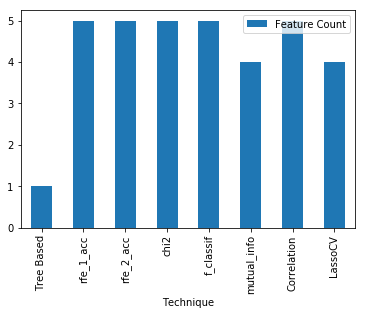

In [ ]:
df_comparison.plot.bar("Technique", "Feature Count")

# Visualization on data

In [ ]:
import seaborn as sns

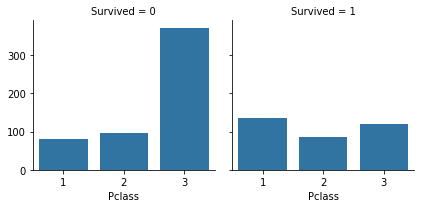

In [ ]:
g = sns.FacetGrid(train_df, col="Survived")
g.map(sns.countplot, "Pclass" )

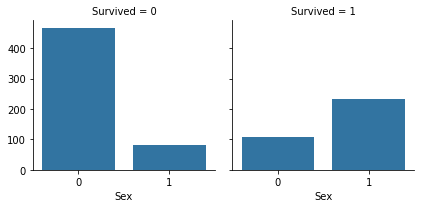

In [ ]:
g = sns.FacetGrid(train_df, col="Survived")
g.map(sns.countplot, "Sex" )
# SEX=>{0: male, 1: Female }

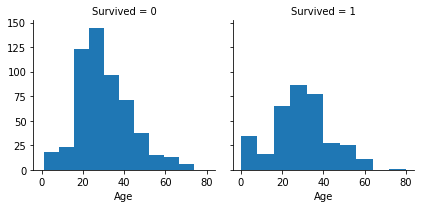

In [ ]:
g = sns.FacetGrid(train_df, col="Survived")
g.map(plt.hist, "Age", bins=10 )